# Quantum Phase Estimation

Quantum phase estimation is one of the most important subroutines in quantum computation. It serves as a central building block for many quantum algorithms. The objective of the algorithm is the following:

Given a unitary operator $U$, the algorithm estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$. Here $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. Since $U$ is unitary, all of its eigenvalues have a norm of 1.

## Quantum Circuit for Phase Estimation 

The general quantum circuit for phase estimation is:
<img src="images/qpe_tex_qz.png">

As mentioned above, this circuit estimates the phase of a unitary operator $U$. It estimates $\theta$ in $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, where $|\psi\rangle$ is an eigenvector and $e^{\boldsymbol{2\pi i}\theta}$ is the corresponding eigenvalue. The circuit operates in the following steps:

0. **Setup**: $\vert\psi\rangle$ is in one set of qubit registers. An additional set of $n$ qubits form an ancilla register: 

$$ \psi_0 = \lvert 0 \rangle^{\otimes n} \lvert \psi \rangle$$ 

1. **Superposition**: Apply a $n$-bit Hadamard gate operation $H^{\otimes n}$ on the ancilla register: 

$$ \psi_1 = {\frac {1}{2^{\frac {n}{2}}}}\left(|0\rangle +|1\rangle \right)^{\otimes n} \lvert \psi \rangle$$

2. **Controlled Unitary Operations**: We need to introduce the controlled unitary $C-U$ that applies the unitary operator $U$ on the target register only if its corresponding control bit is $|1\rangle$. Since $U$ is a unitary operatory with eigenvector $|\psi\rangle$ such that $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, this means: 

$$U^{2^{j}}|\psi \rangle =U^{2^{j}-1}U|\psi \rangle =U^{2^{j}-1}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{j}\theta }|\psi \rangle$$

Applying all the $n$ controlled operations $C − U^{2^j}$ with $0\leq j\leq n-1$, and using the relation $|0\rangle \otimes |\psi \rangle +|1\rangle \otimes e^{2\pi i\theta }|\psi \rangle =\left(|0\rangle +e^{2\pi i\theta }|1\rangle \right)\otimes |\psi \rangle$:

\begin{aligned}
\psi_{2} & =\frac {1}{2^{\frac {n}{2}}} \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{n-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}\vert1\rangle \right) \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}\vert1\rangle \right) \otimes |\psi\rangle\\\\
& = \frac{1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \vert\psi\rangle
\end{aligned}
where $k$ denotes the integer representation of n-bit binary numbers. 

3. **Inverse Fourier Transform**: Notice that the above expression is exactly the result of applying a quantum Fourier transform as we derived in the notebook on [Quantum Fourier Transform and its Qiskit Implementation](qft.ipynb). Recall that QFT maps an n-qubit input state $\vert x\rangle$ into an output as

$$
QFT\vert x \rangle = \frac{1}{2^\frac{n}{2}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right) 
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right) 
$$

Replacing $x$ by $2^n\theta$ in the above expression gives exactly the expression derived in step 2 above. Therefore, to recover the state $\vert2^n\theta\rangle$, apply an inverse Fourier transform on the ancilla register. Doing so, we find

$$
\vert\psi_3\rangle = \frac {1}{2^{\frac {n}{2}}}\sum _{k=0}^{2^{n}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes | \psi \rangle \xrightarrow{\mathcal{QFT}_n^{-1}} \frac {1}{2^n}\sum _{x=0}^{2^{n}-1}\sum _{k=0}^{2^{n}-1} e^{-\frac{2\pi i k}{2^n}(x - 2^n \theta)} |x\rangle \otimes |\psi\rangle
$$ 

4. **Measurement**: 
The above expression peaks near $x = 2^n\theta$. For the case when $2^n\theta$ is an integer, measuring in the computational basis gives the phase in the ancilla register with high probability: 

$$ |\psi_4\rangle = | 2^n \theta \rangle \otimes | \psi \rangle$$

For the case when $2^n\theta$ is not an integer, it can be shown that the above expression still peaks near $x = 2^n\theta$ with probability better than $4/\pi^2 \approx 40\%$ [1].

## Example

Consider a 3-qubit quantum phase estimation of a one-qubit state $\vert\psi\rangle$.

For this example, let us take the unitary matrix to be $Z$. Then, the input state $\vert1\rangle$ is an eigenvector with eigenvalue $-1 = \exp{\left(2\pi i \times 0.5 \right)}$. Hence, $\theta = 0.5$ and $2^n\theta = 2$ if we use $n = 2$ ancilla qubits. 

Note that in this case, the controlled unitary gates are

$$
U^{2^{n-1}} = Z^2 = I
$$
and 
$$
U^{2^{0}} = Z
$$

## Implementation with two ancilla qubits and one state qubit

Now we will implement the above example in Qiskit.

Let's first prepare our environment.

In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

Now, set up the quantum circuit. We will use three qubits -- qubits 0 and 1 as ancilla, and qubit 2 as the eigenstate of the unitary operator. 

We initialize qubit 2 with $\vert\psi\rangle = \vert1\rangle$ by applying an $X$ gate.

In [2]:
q = QuantumRegister(3, 'q')
c = ClassicalRegister(2, 'c')

qpe = QuantumCircuit(q, c)
qpe.x(q[2])

Next, we apply Hadamard gates to the ancilla qubits.

In [3]:
qpe.h(q[0])
qpe.h(q[1])
# Initialization is done, draw a barrier
qpe.barrier()

Next we perform the controlled unitary operations:

In [4]:
# controlled unitary from q[0] is the identity matrix

# controlled unitary from q[1] is a controlled-Z gate
qpe.cz(q[1], q[2]);

We apply quantum inverse Fourier transformation to write the phase to the ancilla register. We will use exactly the code that we wrote to do a $QFT$ and adapt it to be that of $QFT^\dagger$.

In [5]:
# =============================================================================
# Inverse quantum Fourier transform
# =============================================================================
def inverse_qft(circ, q, N):
    control_qubits = range(N)    
    rev = list(reversed(control_qubits))  
    # Swaps are not necessary due to endian ordering
    # Perform the phase rotations
    for i, n in enumerate(rev):
        circ.h(q[i])
        angle = -np.pi/2
        for j in reversed(rev[:n]):
            circ.cu1(angle, q[i], q[j])
            angle /= 2

We then measure the ancilla register:

In [6]:
qpe.barrier()
inverse_qft(qpe, q, 2)

qpe.barrier()
qpe.measure(q[0],c[0])
qpe.measure(q[1],c[1])
# The command below will print the QASM circuit
#print(qpe.qasm())

## Experiment with two ancilla qubits on simulator

{'10': 2048}


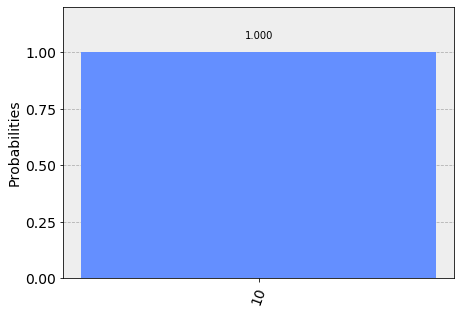

In [8]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpe, backend=backend, shots=shots).result()
answer = results.get_counts()
print(answer)
plot_histogram(answer)

We see that all the tests done on the simulator return the binary string `0.10` corresponding to the decimal value `0.5`. The phase is therefore $\theta=0.5$ and thus the eigenvalue is $e^{2 \pi i \theta} = e^{\pi i} = -1$, as expected.

## Experiment with two ancilla qubits on real quantum device

In [11]:
# Load IBMQ account and get the least busy backend device
from qiskit.providers.ibmq import least_busy

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(simulator=False))
print("Least busy backend: ", backend)

Least busy backend:  ibmq_16_melbourne


Job Status: job has successfully run
{'10': 7150, '00': 827, '11': 163, '01': 52}


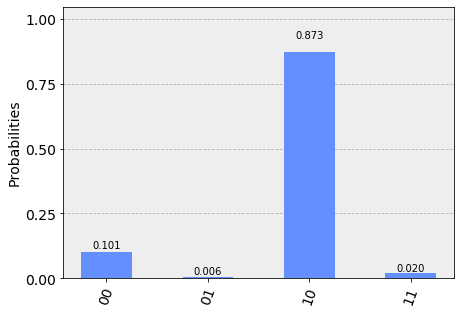

In [12]:
# submit job for execution
from qiskit.tools.monitor import job_monitor

job_exp = execute(qpe, backend=backend, shots=8192)
job_monitor(job_exp, interval = 2)
exp_result = job_exp.result()

exp_measurement_result = exp_result.get_counts(qpe)
print(exp_measurement_result)
plot_histogram(exp_measurement_result)

We see that the great majority (87%) of the tests done on the real device correctly return the binary string `0.10` corresponding to the decimal value `0.5`. 

## Implementation with three ancilla qubits and one state qubit

In [26]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

# =============================================================================
# Inverse quantum Fourier transform
# =============================================================================
def inverse_qft(circ, q, N):
    control_qubits = range(N)    
    rev = list(reversed(control_qubits))

#----------- Not needed
#    # Apply the necessary swaps
#    for i in  range(int(N / 2)):
#        j = N - i - 1
#        circ.swap(i, j)
#------------------------        
    # Phase rotations
    for i, n in enumerate(rev):
        circ.h(q[i])
        angle = -np.pi/2
        for j in reversed(rev[:n]):
            circ.cu1(angle, q[i], q[j])
            angle /= 2

q = QuantumRegister(4, 'q')
c = ClassicalRegister(3, 'c')

qpe3 = QuantumCircuit(q, c)
# Initialization
qpe3.h(q[0])
qpe3.h(q[1])
qpe3.h(q[2])
qpe3.x(q[3])
# Initialization is done, draw a barrier
qpe3.barrier()

# Now apply the controlled gates
# controlled unitary from q[3] is a controlled-Z gate
qpe3.cz(q[2], q[3]);
# controlled unitary from q[2] is the identity matrix
# controlled unitary from q[1] is the identity matrix
#qpe4.cz(q[1], q[4]);
# controlled unitary from q[0] is the identity matrix
#Controlled rotations done, draw barrier
qpe3.barrier()

# Inverse QFT
inverse_qft(qpe3, q, 3)
qpe3.barrier()

# Measurement
qpe3.measure(q[0],c[0])
qpe3.measure(q[1],c[1])
qpe3.measure(q[2],c[2])
#print(qpe3.qasm())

## Experiment with three ancilla qubits on simulator

{'100': 2048}


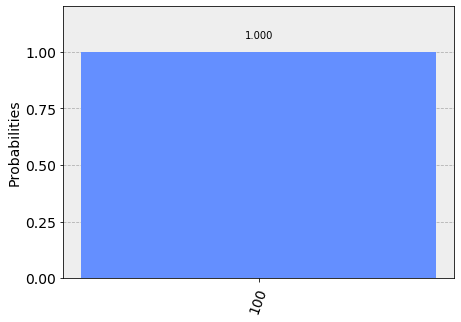

In [28]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpe3, backend=backend, shots=shots).result()
answer = results.get_counts()
print(answer)
plot_histogram(answer)

We again see that 100% of the tests done on the simulator return the binary string `0.100` corresponding to the decimal `0.5`. The phase is therefore $\theta=0.5$ and thus the eigenvalue is $e^{2 \pi i \theta} = e^{\pi i} = -1$.

## Experiment with three ancilla qubits on real quantum device

In [31]:
# Load IBMQ account and get the least busy backend device
from qiskit.providers.ibmq import least_busy

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(simulator=False))
print("Least busy backend: ", backend)

Least busy backend:  ibmq_16_melbourne


Job Status: job has successfully run
{'101': 249, '010': 637, '110': 1640, '011': 58, '001': 80, '100': 4574, '000': 884, '111': 70}


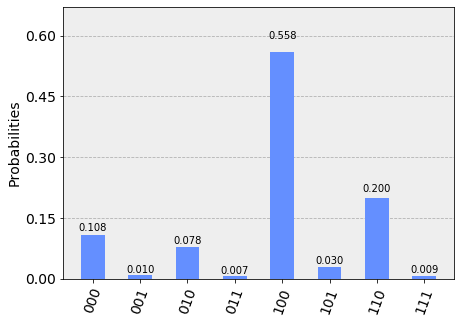

In [30]:
# Run the quantum circuit on least busy device
# submit job for execution
from qiskit.tools.monitor import job_monitor

job_exp = execute(qpe3, backend=backend, shots=8192)
job_monitor(job_exp, interval = 2)
exp_result = job_exp.result()

exp_measurement_result = exp_result.get_counts(qpe3)
print(exp_measurement_result)
plot_histogram(exp_measurement_result)

The tests on the real device still return most of the results as the string `100`, corresponding to the expected eigenvalue. However, there is a clear degradation from the results obtained with only two ancilla qubits. The percentage of correct results decreased to only 56% from 87% in the case of two qubits. Because of noise, further degradation of accuracy can be expected as the number of ancilla qubits is increased.

## Implementation with four ancilla qubits and one state qubit

In [21]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

# =============================================================================
# Inverse quantum Fourier transform
# =============================================================================
def inverse_qft(circ, q, N):
    control_qubits = range(N)    
    rev = list(reversed(control_qubits))

#----------- Not needed
#    # Apply the necessary swaps
#    for i in  range(int(N / 2)):
#        j = N - i - 1
#        circ.swap(i, j)
#------------------------        
    # Phase rotations
    for i, n in enumerate(rev):
        circ.h(q[i])
        angle = -np.pi/2
        for j in reversed(rev[:n]):
            circ.cu1(angle, q[i], q[j])
            angle /= 2

q = QuantumRegister(5, 'q')
c = ClassicalRegister(4, 'c')

qpe4 = QuantumCircuit(q, c)
# Initialization
qpe4.h(q[0])
qpe4.h(q[1])
qpe4.h(q[2])
qpe4.h(q[3])
qpe4.x(q[4])
# Initialization is done, draw a barrier
qpe4.barrier()

# Now apply the controlled gates
# controlled unitary from q[3] is a controlled-Z gate
qpe4.cz(q[3], q[4]);
# controlled unitary from q[2] is the identity matrix
# controlled unitary from q[1] is the identity matrix
#qpe4.cz(q[1], q[4]);
# controlled unitary from q[0] is the identity matrix
#Controlled rotations done, draw barrier
qpe4.barrier()

# Inverse QFT
inverse_qft(qpe4, q, 4)
qpe4.barrier()

# Measurement
qpe4.measure(q[0],c[0])
qpe4.measure(q[1],c[1])
qpe4.measure(q[2],c[2])
qpe4.measure(q[3],c[3])
#print(qpe4.qasm())

## Experiment with four ancilla qubits on simulator

{'1000': 2048}


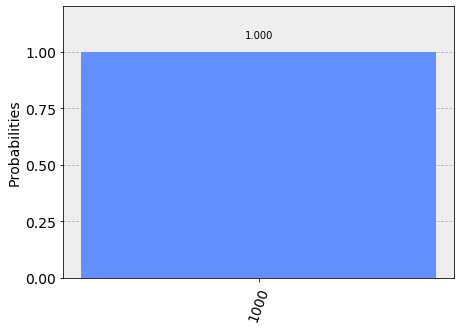

In [23]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 2048
results = execute(qpe4, backend=backend, shots=shots).result()
answer = results.get_counts()
print(answer)
plot_histogram(answer)

We again see that all the tests done on the simulator return the binary string `0.1000`, corresponding to the decimal value `0.5`, as expected. 

## References

[1] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: 10th Anniversary Edition (10th ed.). Cambridge University Press, New York, NY, USA. 